# Aplicação do Modelo Multilíngue XLM-RoBERTa na Análise e Identificação de Grupos de Similaridade de Discursos Políticos

João Pedro Rodrigues Vieira

---

Universidade Presbiteriana Mackenzie - Faculdade de Computação e Informática

Inteligência Artificial - Prof. Dr. Ivan Carlos Alcântara de Oliveira

RA: 10403595

---

Atualizações:
- (22/11/2025) - Adição da Análise

## 0. Preparação do Ambiente

In [1]:
import json;
import torch;
import numpy as np;
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;
from sklearn.manifold import TSNE;
from transformers import AutoTokenizer, AutoModel;

/home/joao/github/political-speech-xlm-r/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Leitura e Tratamento do Dataset

### 1.1 Definição de funções utilitárias

In [2]:
def json_to_dataframe(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f);
        
    df = pd.DataFrame(data["data"]);
    return df;

In [3]:
def transcription_pre_processing(transcription: str) -> str:
    splitted_transcription = transcription.split("-")[2:];
    text = "-".join(splitted_transcription).strip();
    return text;

### 1.2 Carregamento do dataset

In [4]:
df = json_to_dataframe("../dataset/discursos-armamento-2023-2025.json")
df.head()

,idDiscurso,idEvento,descricaoTipoEvento,idDeputado,nomeDeputado,uriDeputado,siglaUf,idLegislatura,siglaPartido,uriPartido,tipoDiscurso,faseEvento,dataHoraInicio,keywords,sumario,transcricao,espectro_politico,posicionamento_ideologico
0,aa6dddcd-b4d4-4c09-b401-3c23b1a100c2,71506,Sessão Deliberativa,73579,Alberto Fraga,https://dadosabertos.camara.leg.br/api/v2/depu...,DF,57,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BREVES COMUNICAÇÕES,Breves Comunicações,2023-12-06T16:44,"Tráfico internacional de arma de fogo,Polícia ...","O Deputado elogiou a Operação Dakovo, que desm...",O SR. ALBERTO FRAGA (PL - DF. Sem revisão do o...,Centro-direita,Conservador
1,0bbb5797-9b23-4ec4-82a4-b9cd5987296a,71506,Sessão Deliberativa,74171,Chico Alencar,https://dadosabertos.camara.leg.br/api/v2/depu...,RJ,57,PSOL,https://dadosabertos.camara.leg.br/api/v2/part...,PELA ORDEM,Ordem do Dia,2023-12-06T22:40,"Federação PSOL REDE,favorável,Estatuto do Desa...","O Deputado, em nome da Federação PSOL REDE, re...",O SR. CHICO ALENCAR (Bloco/PSOL - RJ. Pela ord...,Esquerda,Progressista
2,b2072414-fa5a-4b5b-a7b1-c26c1efdecff,71506,Sessão Deliberativa,156190,Marcel van Hattem,https://dadosabertos.camara.leg.br/api/v2/depu...,RS,57,Novo,https://dadosabertos.camara.leg.br/api/v2/part...,COMO LÍDER,Ordem do Dia,2023-12-06T23:28,"Requerimento de urgência,Projeto de decreto le...",O Deputado expressou sua insatisfação pela der...,O SR. MARCEL VAN HATTEM (NOVO - RS. Como Líder...,Direita,Conservador
3,f5257f2f-b51c-4cb7-bdb0-696df39f0180,71506,Sessão Deliberativa,160575,Erika Kokay,https://dadosabertos.camara.leg.br/api/v2/depu...,DF,57,PT,https://dadosabertos.camara.leg.br/api/v2/part...,PELA ORDEM,Ordem do Dia,2023-12-06T22:52,"Governo,Presidente da República,redução,Assass...",A Deputada enfatizou a importância da verdade ...,A SRA. ERIKA KOKAY (Bloco/PT - DF. Pela ordem....,Esquerda,Progressista
4,f5257f2f-b51c-4cb7-bdb0-696df39f0180,71506,Sessão Deliberativa,160575,Erika Kokay,https://dadosabertos.camara.leg.br/api/v2/depu...,DF,57,PT,https://dadosabertos.camara.leg.br/api/v2/part...,PELA ORDEM,Ordem do Dia,2023-12-06T22:24,"Projeto de decreto legislativo,sustação,Decret...",A Deputada manifestou sua preocupação com a te...,A SRA. ERIKA KOKAY (Bloco/PT - DF. Pela ordem....,Esquerda,Progressista


#

In [5]:
df["siglaPartido"].unique()

array(['PL', 'PSOL', 'Novo', 'PT', 'Republican', 'União', 'PP', 'UNIÃO',
       'MDB', 'PSD'], dtype=object)

In [6]:
# Normalizando a siglas de partidos políticos
df["siglaPartido"] = df["siglaPartido"].apply(str.upper);
df["siglaPartido"].unique()

array(['PL', 'PSOL', 'NOVO', 'PT', 'REPUBLICAN', 'UNIÃO', 'PP', 'MDB',
       'PSD'], dtype=object)

In [7]:
df["transcricao"] = df["transcricao"].apply(transcription_pre_processing)

In [8]:
df["transcricao"].head()

0    Muito obrigado, Presidente. Sr. Presidente, on...
1    A Federação PSOL REDE é pelo desarmamento, por...
2    Nós já temos tão pouquinho tempo! Mas é bom qu...
3    Em nome da verdade, que é ameaçada todos os di...
4    Presidente, nós aqui vimos uma cena que rompe ...
Name: transcricao, dtype: object

## 2. Geração de Embeddings com XLM-R

### 2.1. Inicialização do tokenizer e modelo

In [9]:
# Verificando a disponibilidade de GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo a ser utilizado: {device}");

Dispositivo a ser utilizado: cuda


In [10]:
model = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model);
xlm_r_model = AutoModel.from_pretrained(model).to(device);

### 2.2 Tokenização dos textos

In [11]:
# Seleção dos textos de transcrição e sumário

transcription_texts = df["transcricao"].tolist();
summary_texts = df["sumario"].tolist();

In [12]:
transcription_tokens = tokenizer(transcription_texts, padding=True, truncation=True, return_tensors="pt").to(device);
summary_tokens = tokenizer(summary_texts, padding=True, truncation=True, return_tensors="pt").to(device);

### 2.3 Geração de embeddings

In [13]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state;
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float();

    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9);

In [14]:
# Obtendo embeddings relativos às transcrições integrais dos discursos
# de membros da Câmara dos Deputados do Brasil

with torch.no_grad():
    transcription_outputs = xlm_r_model(**transcription_tokens);
    transcription_embeddings = mean_pooling(transcription_outputs, transcription_tokens['attention_mask']);

In [15]:
# Obtendo embeddings provenientes dos sumários destes discursos, ofertado 
# também pela Câmara

with torch.no_grad():
    summary_outputs = xlm_r_model(**summary_tokens);
    summary_embeddings = mean_pooling(summary_outputs, summary_tokens['attention_mask']);

## 3. Visualização dos Resultados via t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [16]:
# Garantindo que os embeddings estejam em CPU para conversão via NumPy

transc_np_array = transcription_embeddings.cpu().numpy();
summary_np_array = summary_embeddings.cpu().numpy();

In [17]:
# Obtendo as visualizações 2D via t-SNE
print("Transcrições");
tsne = TSNE(n_components=2, metric="cosine", learning_rate="auto", random_state=34, verbose=1);
transc_visualization_2d = tsne.fit_transform(transc_np_array);

print("-------------------");
print("Sumários");
tsne = TSNE(n_components=2, metric="cosine", learning_rate="auto", random_state=34, verbose=1);
summary_visualization_2d = tsne.fit_transform(summary_np_array);

Transcrições
[t-SNE] Computing 54 nearest neighbors...
[t-SNE] Indexed 55 samples in 0.000s...
[t-SNE] Computed neighbors for 55 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 55 / 55
[t-SNE] Mean sigma: 0.000442
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.892632
[t-SNE] KL divergence after 1000 iterations: 0.101056
-------------------
Sumários
[t-SNE] Computing 54 nearest neighbors...
[t-SNE] Indexed 55 samples in 0.000s...
[t-SNE] Computed neighbors for 55 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 55 / 55
[t-SNE] Mean sigma: 0.000517
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.296860
[t-SNE] KL divergence after 950 iterations: 0.103851


## 4. Visualização dos Resultados

In [18]:
# Importando datetime para marcação temporal dos gráficos (útil para salvar imagens)

from datetime import datetime as dt;

### 4.1. Aplicação do t-SNE

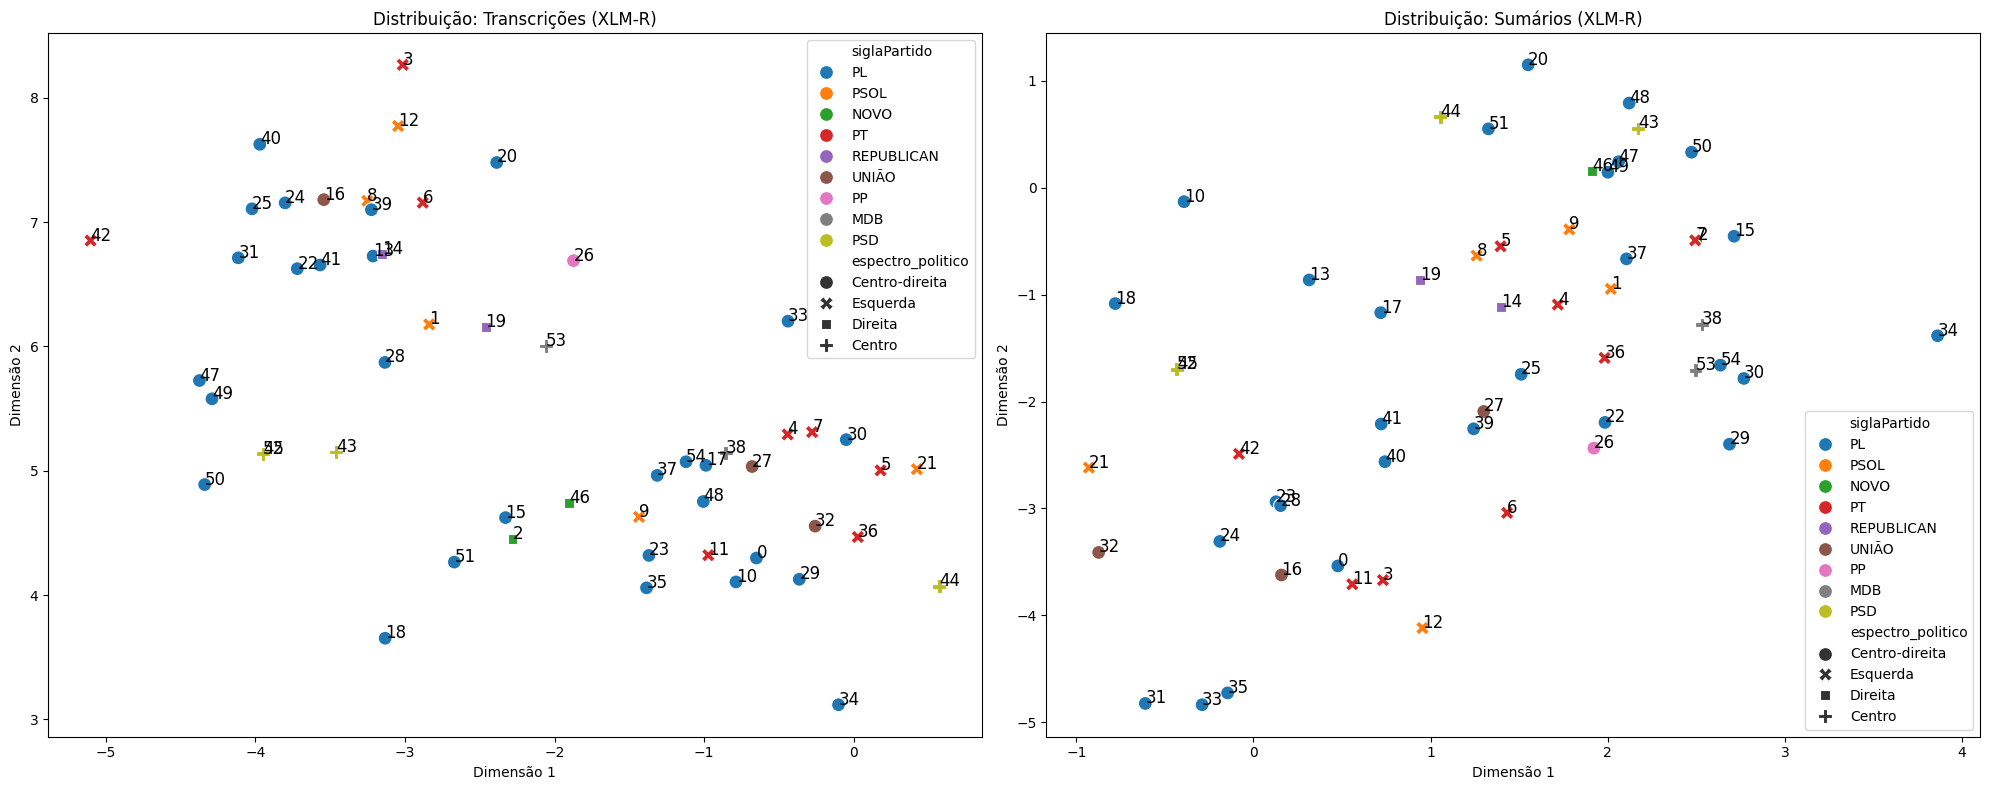

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.scatterplot(
    x=transc_visualization_2d[:, 0], 
    y=transc_visualization_2d[:, 1], 
    hue=df['siglaPartido'], 
    style=df['espectro_politico'],
    s=100,
    ax=axes[0]
)

for i, txt in enumerate(df.index):
    axes[0].annotate(txt, (transc_visualization_2d[i, 0], transc_visualization_2d[i, 1]), fontsize=12, color="black", alpha=1.0)

axes[0].set_title("Distribuição: Transcrições (XLM-R)")
axes[0].set_xlabel("Dimensão 1")
axes[0].set_ylabel("Dimensão 2")

# axes[0].get_legend().remove() 

sns.scatterplot(
    x=summary_visualization_2d[:, 0], 
    y=summary_visualization_2d[:, 1], 
    hue=df['siglaPartido'], 
    style=df['espectro_politico'],
    s=100,
    ax=axes[1]
)

for i, txt in enumerate(df.index):
    axes[1].annotate(txt, (summary_visualization_2d[i, 0], summary_visualization_2d[i, 1]), fontsize=12, color="black", alpha=1.0)

axes[1].set_title("Distribuição: Sumários (XLM-R)")
axes[1].set_xlabel("Dimensão 1")
axes[1].set_ylabel("Dimensão 2")

plt.tight_layout()

datetime_str = dt.now().strftime("%Y-%m-%d")
plt.savefig(f"../plots/comparativo_tsne_xlmr_{datetime_str}.png", dpi=600)

plt.show()

### Primeira análise: transcrições dessemelhantes, sumários semelhantes

#### Espectro político: esquerda

In [20]:
print("Discurso índice 5:");
print(transcription_texts[5]);
print();

print("Discurso índice 8:");
print(transcription_texts[8]);
print();

Discurso índice 5:
A Polícia Federal, em uma operação conjunta entre Brasil, Paraguai e Estados Unidos, apreendeu uma quadrilha que, em 3 anos, movimentou por volta de 1,2 bilhão de reais e disponibilizou 43 mil fuzis e pistolas que chegaram às mãos de criminosos. Liberar as armas significa colocar mais armas nas mãos dos criminosos. Aliás, quem defende as forças de segurança do nosso País deveria defender que elas detivessem o monopólio das armas. Dizer que as mulheres têm que defender a si próprias e tirar a responsabilidade do Estado é coisa de quem é vassalo ou sabujo de um Presidente que, por diversas vezes, expressou, sem nenhum pudor, o seu sexismo e a sua misoginia. Nós estamos aqui, nesta noite de hoje, para aprovar uma pauta que nos permita fazer entregas à sociedade sobre mecanismos e instrumentos para se avançar no enfrentamento da violência contra as mulheres. Os 21 dias de ativismo se encerram no próximo dia 10, que é o Dia Internacional dos Direitos Humanos. Esse projeto

In [21]:
print("Sumário índice 5:");
print(summary_texts[5]);
print();

print("Sumário índice 8:");
print(summary_texts[8]);
print();

Sumário índice 5:
A Deputada discutiu o Projeto de Lei nº 1.213, de 2022, que altera a Lei nº 14.149, de 5 de maio de 2021, para dispor sobre a aplicação obrigatória do Formulário Nacional de Avaliação de Risco no âmbito das Polícias Civis dos Estados e do Distrito Federal. Além disso, destacou a importância de focar em medidas efetivas para enfrentar a violência contra as mulheres, criticando a ideia de armar as mulheres como solução para a segurança. Mencionou a operação conjunta entre Brasil, Paraguai e Estados Unidos, que apreendeu uma quadrilha envolvida na movimentação de bilhões de reais e disponibilização de armas para criminosos.

Sumário índice 8:
A Deputada orientou a bancada na votação do Requerimento de Urgência para apreciação do Projeto de Lei nº 5.711, de 2023, que dispõe sobre a atuação do Tribunal de Contas da União como membro do Conselho de Auditores da Organização das Nações Unidas. Além disso, antecipou a orientação para o suposto próximo requerimento de urgência 

#### Comparativo: discursos da direita, em que os sumários apresentaram semelhança com os da esquerda

In [22]:
print("Transcrição índice 14:");
print(transcription_texts[14]);
print();

print("Transcrição índice 19:");
print(transcription_texts[19]);
print();

Transcrição índice 14:
Presidente, nós tivemos 254 votos para aprovar o requerimento de urgência. O Governo está comemorando cedo demais. O Governo, que condena quem tem CPF e CNPJ, que condena clubes de tiro, colecionadores, atiradores e caçadores, não apresenta uma política pública de segurança contrária às facções criminosas. Qual é a política que ele apresentou contra o PCC, contra o Comando Vermelho? Nenhuma! Porém, contra os CACs, contra os clubes de tiro, contra os atiradores, sim. Nessa hora, as armas são um problema. Isso é irresponsabilidade! Mas eu deixo claro aqui que iremos apresentar novamente um pedido de urgência. E, dessa vez, Parlamentares covardes e medrosos que não votarem serão cobrados. Nós não podemos, em uma sociedade que quer seu direito à legítima defesa, ter representantes covardes. Queremos saber quem é desarmamentista e quem quer, sim, a liberdade para que a pessoa tenha o direito de ter posse e porte de armas. Fica registrado que iremos apresentar um reque

In [23]:
print("Sumário índice 14:");
print(summary_texts[14]);
print();

print("Sumário índice 19:");
print(summary_texts[19]);
print();

Sumário índice 14:
O Deputado expressou sua insatisfação pela derrota na votação sobre a urgência do Projeto de Decreto Legislativo nº 3, de 2023, que susta o Decreto nº 11.366, de 1º de janeiro 2023, que limita o registro e a aquisição de armas de fogos. Criticou o Governo Federal pela ausência de políticas de segurança efetivas contra facções criminosas e prometeu apresentar novamente o pedido de urgência sobre a matéria, destacando a necessidade de identificar quem é a favor do desarmamento e quem defende a liberdade para que as pessoas tenham o direito de posse e porte de armas.

Sumário índice 19:
A Deputada destacou a importância das proposições de proteção às mulheres em votação na Casa. Ressaltou a trágica situação de violência contra mulheres no Estado do Maranhão, mencionando casos específicos de feminicídio. Por fim, apoiou o requerimento de urgência para a votação do Projeto de Decreto Legislativo nº 3, de 2023, que susta o Decreto nº 11.366, de 1º de janeiro 2023, que limi

### Segunda análise: transcrições semelhantes, sumários dessemelhantes

#### Espectro político: esquerda

In [24]:
print("Discurso índice 5:");
print(transcription_texts[5]);
print();

print("Discurso índice 21:");
print(transcription_texts[21]);
print();

Discurso índice 5:
A Polícia Federal, em uma operação conjunta entre Brasil, Paraguai e Estados Unidos, apreendeu uma quadrilha que, em 3 anos, movimentou por volta de 1,2 bilhão de reais e disponibilizou 43 mil fuzis e pistolas que chegaram às mãos de criminosos. Liberar as armas significa colocar mais armas nas mãos dos criminosos. Aliás, quem defende as forças de segurança do nosso País deveria defender que elas detivessem o monopólio das armas. Dizer que as mulheres têm que defender a si próprias e tirar a responsabilidade do Estado é coisa de quem é vassalo ou sabujo de um Presidente que, por diversas vezes, expressou, sem nenhum pudor, o seu sexismo e a sua misoginia. Nós estamos aqui, nesta noite de hoje, para aprovar uma pauta que nos permita fazer entregas à sociedade sobre mecanismos e instrumentos para se avançar no enfrentamento da violência contra as mulheres. Os 21 dias de ativismo se encerram no próximo dia 10, que é o Dia Internacional dos Direitos Humanos. Esse projeto

In [25]:
print("Sumário índice 5:");
print(summary_texts[5]);
print();

print("Sumário índice 21:");
print(summary_texts[21]);
print();

Sumário índice 5:
A Deputada discutiu o Projeto de Lei nº 1.213, de 2022, que altera a Lei nº 14.149, de 5 de maio de 2021, para dispor sobre a aplicação obrigatória do Formulário Nacional de Avaliação de Risco no âmbito das Polícias Civis dos Estados e do Distrito Federal. Além disso, destacou a importância de focar em medidas efetivas para enfrentar a violência contra as mulheres, criticando a ideia de armar as mulheres como solução para a segurança. Mencionou a operação conjunta entre Brasil, Paraguai e Estados Unidos, que apreendeu uma quadrilha envolvida na movimentação de bilhões de reais e disponibilização de armas para criminosos.

Sumário índice 21:
Desafio do governo petista de defesa da democracia e combate à política de ódio e violência. Importância das restrições impostas à comercialização de armas de fogo e munições. Defesa de aprovação do Projeto de Lei nº 2.630, de 2020, sobre a instituição da Lei Brasileira de Liberdade, Responsabilidade e Transparência na Internet (pr

### 4.2. Similaridade de Cosseno

In [26]:
# Importando a função de similaridade de cosseno

from sklearn.metrics.pairwise import cosine_similarity

In [27]:
def plot_heatmap(cos_sim_matrix, title, xlabel, ylabel, save_path, cmap="rocket", linecolor="white"):
    """
    Função para plotar um heatmap a partir de uma matriz de similaridade por cosseno.
    Parâmetros:
    - cos_sim_matrix: Matriz de similaridade por cosseno a ser visualizada
    - title: Título do gráfico
    - xlabel: Rótulo do eixo X
    - ylabel: Rótulo do eixo Y
    - save_path: Caminho para salvar a imagem do heatmap
    - cmap: Mapa de cores a ser utilizado no heatmap (padrão: "rocket")
    - linecolor: Cor das linhas que separam as células do heatmap (padrão: "white")
    """
    
    plt.figure(figsize=(12, 10));

    sns.heatmap(cos_sim_matrix, linewidths=.5, linecolor=linecolor, cmap=cmap);

    plt.title(title);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);

    datetime = dt.now().strftime("%Y-%m-%d");
    plt.savefig(f"{save_path}_{datetime}.png", dpi=600);
    
    plt.show();

#### 4.2.1 Transcrições

In [28]:
transc_cos_sim_matrix = cosine_similarity(transc_visualization_2d);

print("cos_sim_matrix shape:", transc_cos_sim_matrix.shape);
transc_cos_sim_matrix[0].dtype

cos_sim_matrix shape: (55, 55)


dtype('float32')

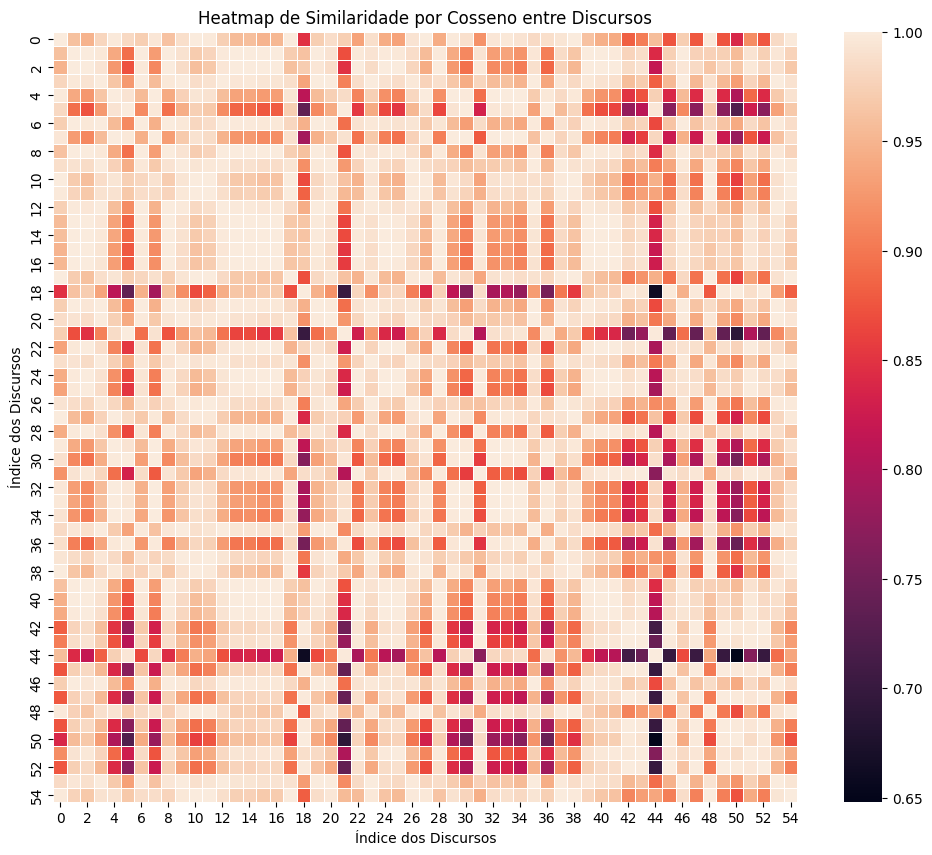

In [29]:
plot_heatmap(
    cos_sim_matrix=transc_cos_sim_matrix,
    title="Heatmap de Similaridade por Cosseno entre Discursos",
    xlabel="Índice dos Discursos",
    ylabel="Índice dos Discursos",
    save_path="../plots/heatmap-similaridade-cosseno-discursos-xlm-r"
);

#### 4.2.2 Sumários

In [30]:
summary_cos_sim_matrix = cosine_similarity(summary_visualization_2d);

print("cos_sim_matrix shape:", summary_cos_sim_matrix.shape);
summary_cos_sim_matrix[0].dtype

cos_sim_matrix shape: (55, 55)


dtype('float32')

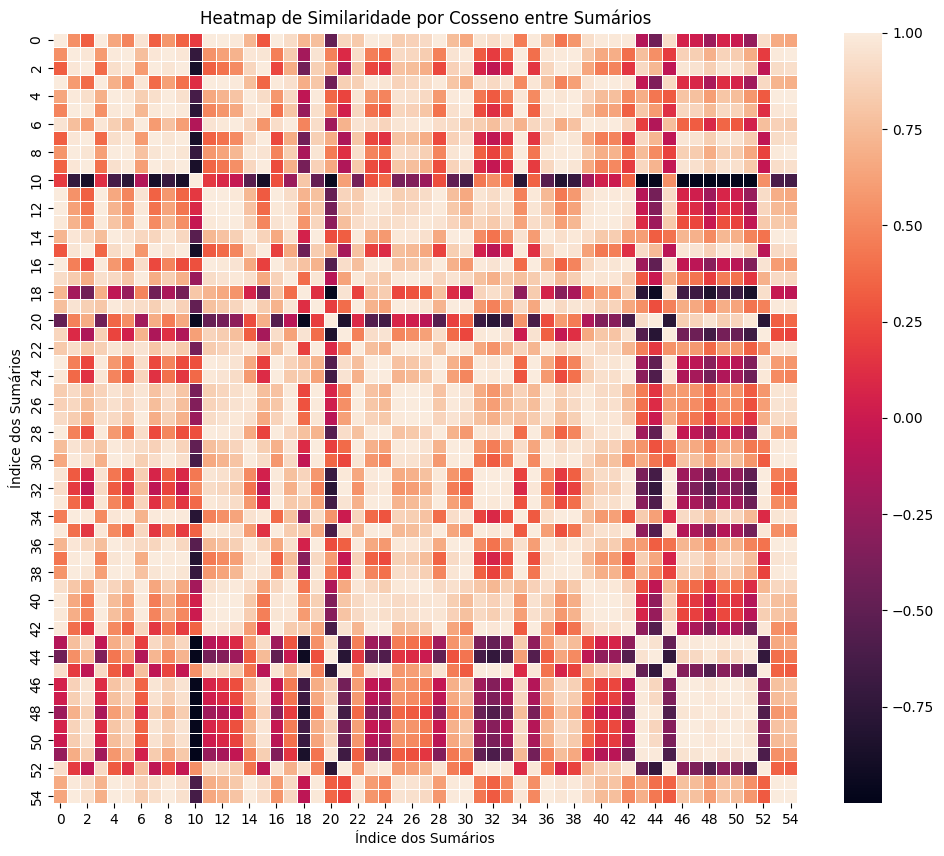

In [31]:
plot_heatmap(
    cos_sim_matrix=summary_cos_sim_matrix,
    title="Heatmap de Similaridade por Cosseno entre Sumários",
    xlabel="Índice dos Sumários",
    ylabel="Índice dos Sumários",
    save_path="../plots/heatmap-similaridade-cosseno-sumarios-xlm-r"
);